In [2]:



# finalDF["isIn100PercentBucketWithFilter"] = ( (finalDF['compatibilityPercentageNoDecay'] ==1.0) & (finalDF["hasTransitionOverlapDecay"]))
# finalDF["isIn70PercentBucket"] = ( (finalDF['compatibilityPercentageNoDecay'] >=0.7) & (finalDF["hasTransitionOverlapDecay"]))
#
# scoreNames = ["isInExactMatchBlocking","isInSequenceBlocking","isInValueSetBlocking",
#               "isInStrictBlockingNoDecay","isIn70PercentBucket","isIn100PercentBucket",
#               "isIn100PercentBucketWithFilter","isIn70PercentBucket"]
# for bucketName in scoreNames:
#     rr = sum(finalDF[bucketName]) / len(finalDF.index)
#     print(bucketName, rr)

In [3]:

#df = pd.read_csv("localData/semanticAnnotation/results.csv")
OLD=False # old or new gold standard
df = rm.readGoldStandardEvaluation(OLD)

#TODO about the filtering! Currently we are not applying the transition filters to CBRB and CBRB NoDecay but the table in the paper does - we need to choose what we want to represent in the final matrix

print(df.dtypes)



print(df["weight"])
#print(df.describe())
# plot = ggplot(df,aes(x = 'isSemanticRoleMatch',fill="dataset",group='dataset')) + geom_histogram(position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))
# print(plot)
# plot = ggplot(df,aes(x = 'compatibilityPercentageDecay',fill="dataset")) + geom_histogram(position=position_dodge())
# print(plot)

# for dsName in df.dataset.unique():
#     thisDF = df[df['dataset']==dsName]
#     print(dsName,"Positive Rate: ", sum(thisDF['isSemanticRoleMatch']) / len(thisDF.index) )
#     print(dsName,"Positive Counts/Rate in Compatible (with Decay): ",sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingDecay']), "/", sum(thisDF['isInStrictBlockingDecay']),sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingDecay']) / sum(thisDF['isInStrictBlockingDecay']) )
#
#     print(dsName,"Counts/Percentage of Semantic Being Compatible (with Decay): ",sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingDecay']),"/",sum(thisDF['isSemanticRoleMatch']), sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingDecay']) / sum(thisDF['isSemanticRoleMatch']) )
#     print(dsName,"Positive Counts/Rate in Compatible (without Decay): ",sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingNoDecay']),"/",sum(thisDF['isInStrictBlockingNoDecay']), sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingNoDecay']) / sum(thisDF['isInStrictBlockingNoDecay']) )
#     print(dsName,"Counts/Percentage of Semantic Being Compatible (without Decay): ",sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingNoDecay']),"/",sum(thisDF['isSemanticRoleMatch']), sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingNoDecay']) / sum(thisDF['isSemanticRoleMatch']) )

/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  largeSampleDF = largeSampleDF.append(df)
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  largeSampleDF = largeSampleDF.append(df)
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  largeSampleDF = largeSampleDF.append(df)
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

dataset                                           object
id1                                               object
id2                                               object
isInStrictBlockingDecay                             bool
isInStrictBlockingNoDecay                           bool
isInValueSetBlocking                                bool
isInSequenceBlocking                                bool
isInExactMatchBlocking                              bool
isSemanticRoleMatch                                 bool
compatibilityPercentageDecay                     float64
compatibilityPercentageNoDecay                   float64
exactSequenceMatchPercentage                     float64
hasTransitionOverlapNoDecay                         bool
hasTransitionOverlapDecay                           bool
hasValueSetOverlap                                  bool
isInSVABlockingNoDecay                              bool
isInSVABlockingDecay                                bool
VACount                        

/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  largeSampleDF = largeSampleDF.append(df)


In [4]:
interesting = df[(df['isSemanticRoleMatch']) & (df['isInStrictBlockingNoDecayWithFilter']) & (~df['isInExactMatchBlockingWithFilter'])]
print(interesting[['dataset','id1','id2']].values)

[['tv_and_film'
  'infobox television episode||4087244||228832498-0||series'
  'infobox television episode||7173422||221558159-0||series']
 ['tv_and_film'
  'infobox television episode||21996362||277577220-0||episode list'
  'infobox television episode||894152||286226731-0||episode list']
 ['tv_and_film'
  'infobox television episode||19474491||241008508-0||series'
  'infobox television episode||9808954||223161959-0||series']
 ['tv_and_film' 'infobox television episode||2298981||19504928-0||series'
  'infobox television episode||2564637||22063879-0||series']
 ['tv_and_film' 'infobox television episode||2160093||18606921-0||series'
  'infobox television episode||2298998||19505098-0||series']
 ['tv_and_film'
  'infobox television episode||16704086||223847795-0||series'
  'infobox television episode||19474322||241005943-0||series']
 ['tv_and_film'
  'infobox television episode||17114960||224036703-0||series'
  'infobox television episode||4493844||229777044-0||series']
 ['tv_and_film'
  '

In [5]:
rm.addDVA2VA95Blocking(df)
print(len(df[~df['isInDVA2VA95Blocking']].index))
print(len(df[df['isInDVA2VA95Blocking']].index))
print(df[(~df['isInDVA2VA95Blocking']) & df['isSemanticRoleMatch']])

0
1500
Empty DataFrame
Columns: [dataset, id1, id2, isInStrictBlockingDecay, isInStrictBlockingNoDecay, isInValueSetBlocking, isInSequenceBlocking, isInExactMatchBlocking, isSemanticRoleMatch, compatibilityPercentageDecay, compatibilityPercentageNoDecay, exactSequenceMatchPercentage, hasTransitionOverlapNoDecay, hasTransitionOverlapDecay, hasValueSetOverlap, isInSVABlockingNoDecay, isInSVABlockingDecay, VACount, DVACount, isInTSMBlockingNoWildcard, isInTSMBlockingWithWildcard, strictlyCompatiblePercentage, decayScore, isInCBRB, isInCBRBNoDecay, isInCBRBWithTransitionFilter, isInCBRBNoDecayWithTransitionFilter, isInStrictBlockingDecayWithTransitionFilter, isInStrictBlockingNoDecayWithTransitionFilter, isInStrictCompatibleBlocking, isInStrictBlockingNoDecayWithFilter, isInValueSetBlockingWithFilter, isInSequenceBlockingWithFilter, isInExactMatchBlockingWithFilter, isInTSMBlockingWithFilter, bucket, weight, isInDVA2VA95Blocking]
Index: []

[0 rows x 38 columns]


In [6]:
print(df[(df['isSemanticRoleMatch']) & (df['bucket']=="[0.7,1.0) (70%)")]["compatibilityPercentageNoDecay"])

48      0.991379
131     0.994253
185     0.991379
187     0.988506
260     0.892241
364     0.995690
489     0.988506
574     0.974138
951     0.982759
968     0.981322
969     0.945402
1077    0.961207
Name: compatibilityPercentageNoDecay, dtype: float64


In [7]:
print(df[(df['isSemanticRoleMatch']) & (df['isInStrictBlockingNoDecay']) & (~df['isInStrictBlockingNoDecayWithFilter'])][['id1','id2']])
df[(df['isSemanticRoleMatch']) & (df['isInStrictBlockingNoDecay']) & (~df['isInStrictBlockingNoDecayWithFilter'])][['dataset','id1','id2']].to_csv("gs1errors.csv")
#df["newLabel"] = (df['isSemanticRoleMatch']) | ((df['isSemanticRoleMatch']) & (df['isInStrictBlockingNoDecay']) & (~df['isInStrictBlockingNoDecayWithFilter']))
#print(sum(df["newLabel"]))
#print(sum(df["isSemanticRoleMatch"]))

Empty DataFrame
Columns: [id1, id2]
Index: []


# Precision / Recall / F1

In [1]:
import role_matching.EvaluationHelperMethods as rm
import role_matching.MetricHelperMethods as mhm
import pandas as pd
from plotnine import *
from plotnine.data import *
from tabulate import tabulate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
import numpy as np

bucketAndDatasetToWeight, _ = rm.getBucketAndDatasetToWeight()

OLD = True
if(OLD):
    weighted = False
else:
    weighted = True
df = rm.readGoldStandardEvaluation(OLD)
#df['isInStrictBlockingNoDecayWithFilter']
methodNames = ['isInExactMatchBlockingWithFilter','isInStrictBlockingNoDecayWithFilter','isInSequenceBlockingWithFilter','isInTSMBlockingWithFilter','isInValueSetBlockingWithFilter']
               #'isInExactMatchBlockingWithFilter','isInSequenceBlockingWithFilter','isInValueSetBlockingWithFilter','isInStrictBlockingNoDecayWithFilter']

#print("dataset","#TP","EM,,","CSM,,","VSM,,","RM,,","FCBRM (ND),,","FCBRM (D),,","CBRM (ND),,","CBRM (D),,",sep=",")
print("dataset","#TP","EM","CBRB","QSM","TSM","VSM",sep=",")
print("," + (",R"* (len(methodNames))))
#print(",,P,R,F1","P,R,F1","P,R,F1","P,R,F1","P,R,F1",sep=",")
dsNameList = []
for dsName in df['dataset'].unique():
    dsNameList.append(dsName)
dsNameList.sort()
for dsName in dsNameList:
    shortName = rm.datasetToAbbreviation[dsName]
    mhm.printRecallForNonparametrizedMethodsDF(shortName,df[df['dataset']==dsName],methodNames,weighted,bucketAndDatasetToWeight)
mhm.printRecallForNonparametrizedMethodsDF("Micro-AVG",df,methodNames,weighted,bucketAndDatasetToWeight)
mhm.printMacroAveragesRecall("Macro-AVG",df,methodNames,weighted,bucketAndDatasetToWeight)

/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.

dataset,#TP,EM,CBRB,QSM,TSM,VSM
,,R,R,R,R,R
ED,19,36,78,57,73,73
FO,44,88,93,90,93,95
MI,21,23,57,33,33,33
PO,33,45,60,54,60,63
TV,36,41,77,66,75,75
Micro-AVG,153,52,75,65,71,72
Macro-AVG,,47,73,60,67,68,

In [5]:
df1 = rm.readGoldStandardEvaluation(OLD)
df2 = rm.readGoldStandardEvaluation(OLD)
dfAll = df1.append(df2)
dfAllTP = dfAll[dfAll['isSemanticRoleMatch']]
print(sum(dfAllTP["hasNonOverlap"]) / len(dfAllTP.index))
print(sum(~ dfAllTP["isInStrictBlockingNoDecay"]) / len(dfAllTP.index))
print(sum( dfAllTP["compatibilityPercentageNoDecay"] != 1.0) / len(dfAllTP.index))

/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.

0.32679738562091504
0.24183006535947713
0.24183006535947713


/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_9576/2047925947.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [9]:
#
#Returned number of pairs vs Recall:
print("dataset","#TP","EM,","CSM,","VSM,","FCBRM (ND),","FCBRM (NDWF),",sep=",")
print(",,N,R","N,R","N,R","N,R","N,R",sep=",")
methods = ['isInExactMatchBlocking','isInSequenceBlocking','isInValueSetBlocking','isInStrictBlockingNoDecay','isInStrictBlockingNoDecayWithFilter']
dsNameList = []
for dsName in df['dataset'].unique():
    dsNameList.append(dsName)
dsNameList.sort()
for dsName in dsNameList:
    shortName = datasetToAbbreviation[dsName]
    mhm.printNAndRecallForNonparametrizedMethodsDF(shortName,df[df['dataset']==dsName],methods)
mhm.printNAndRecallForNonparametrizedMethodsDF("Micro-AVG",df,methods)
mhm.printMacroAveragesNAndRecall("Macro-AVG",df,methods)

dataset,#TP,EM,,CSM,,VSM,,FCBRM (ND),,FCBRM (NDWF),
,,N,R,N,R,N,R,N,R,N,R


NameError: name 'datasetToAbbreviation' is not defined

# Tabular Overview over True Semantic Matches

In [ ]:
# true positives:
dfTruePositivesOnly = df[df['isSemanticRoleMatch']]
tab = dfTruePositivesOnly.groupby(['dataset','bucket']).size()
print(tab)

/tmp/ipykernel_5393/642294572.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_5393/642294572.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


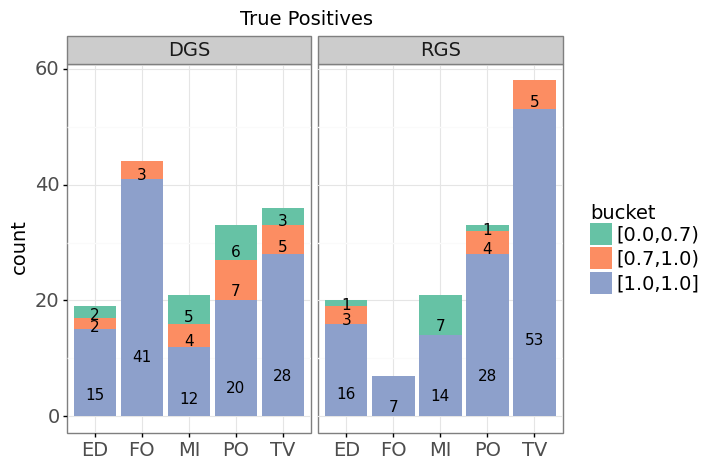

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/truePositivesBoth.png
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


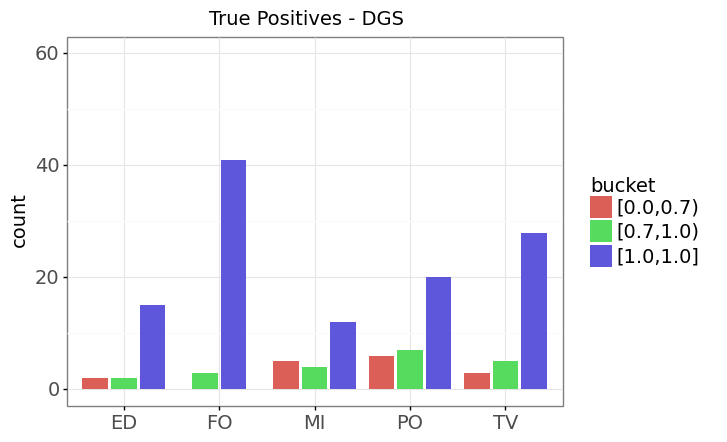

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/dgs.png


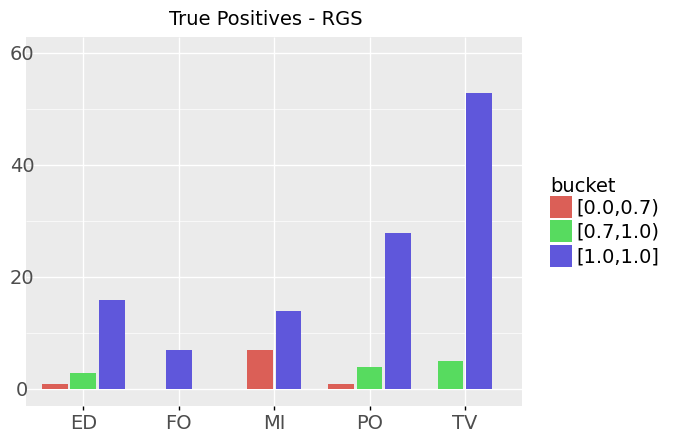


0.7581699346405228
0.8489208633093526
0.7581699346405228
0.8489208633093526


/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/rgs.png


In [24]:
import role_matching.EvaluationHelperMethods as rm
OLD=True # old or new gold standard


df1 = pd.read_csv("localData/semanticAnnotation/gs1/results.csv")
df1["GS"] = "DGS"
df2 = pd.read_csv("localData/semanticAnnotation/gs2/results.csv")
df2["GS"] = "RGS"
df = df1.append(df2)

rm.addFilteredBlockingMethods(df1)
rm.addFilteredBlockingMethods(df2)
rm.addShortDataset(df1)
rm.addShortDataset(df2)
df1['bucket'] = df1['compatibilityPercentageNoDecay'].map(lambda x: rm.getShortGroup(x))
df2['bucket'] = df2['compatibilityPercentageNoDecay'].map(lambda x: rm.getShortGroup(x))

#histogram
dfTruePositivesOnlyDF1 = df1[df1['isSemanticRoleMatch']]
dfTruePositivesOnlyDF2 = df2[df2['isSemanticRoleMatch']]
dfAllPositives = dfTruePositivesOnlyDF1.append(dfTruePositivesOnlyDF2)

cbPalette = ["#1b9e77", "#d95f02", "#7570b3", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plot = ggplot(dfAllPositives,aes(x = 'datasetShort',fill="bucket")) +xlab("") + geom_bar(stat = "count") + facet_wrap("GS") + theme_bw() + ggtitle("True Positives") + theme(text=element_text(size=14)) +  geom_text(aes(label = "..count.."),position = position_stack(vjust = 0.25), stat = "count")+ scale_fill_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exportedPlots/truePositivesBoth.png")

plot = ggplot(dfTruePositivesOnlyDF1,aes(x = 'datasetShort',fill="bucket")) +xlab("") + theme_bw() + geom_bar(position=position_dodge2(preserve = "single")) + ggtitle("True Positives - DGS") + ylim(0,60) + theme(text=element_text(size=14)) \
       #+  geom_text(aes(label = "..count.."), stat = "count")
print(plot)
plot.save("exportedPlots/dgs.png")
plot = ggplot(dfTruePositivesOnlyDF2,aes(x = 'datasetShort',fill="bucket")) +xlab("") + ylab("")+ ylim(0,60) +theme(axis_title_y=element_blank(),axis_text_y=element_blank(),axis_ticks_major_y=element_blank(),axis_ticks_minor_y=element_blank()) + geom_bar(position=position_dodge2(preserve = "single")) + ggtitle("True Positives - RGS")  + theme(text=element_text(size=14))
       #+  geom_text(aes(label = "..count.."),nudge_x=0.2, stat = "count")
print(plot)
plot.save("exportedPlots/rgs.png")

print(sum((dfTruePositivesOnlyDF1['bucket']=="[1.0,1.0]")) / len(dfTruePositivesOnlyDF1.index))
print(sum((dfTruePositivesOnlyDF2['bucket']=="[1.0,1.0]")) / len(dfTruePositivesOnlyDF2.index))
print(sum((dfTruePositivesOnlyDF1['isInStrictBlockingNoDecayWithFilter'])) / len(dfTruePositivesOnlyDF1.index))
print(sum((dfTruePositivesOnlyDF2['isInStrictBlockingNoDecayWithFilter'])) / len(dfTruePositivesOnlyDF2.index))

# Tabular Overview over True Semantic Matches Sorted by Compatibility

In [ ]:
dfTruePositives = df[df['isSemanticRoleMatch']]
#For Decay:
dfTruePositives.sort_values('compatibilityPercentageDecay',inplace=True)
print(tabulate(dfTruePositives, headers='keys', tablefmt='psql'))
#Total:
print(sum(df['isSemanticRoleMatch']))
print(sum(df['isSemanticRoleMatch'] & df['isInStrictBlockingDecay']))
# For No Decay:
dfTruePositives.sort_values('compatibilityPercentageNoDecay',inplace=True)
print(tabulate(dfTruePositives, headers='keys', tablefmt='psql'))
#Total:
print(sum(df['isSemanticRoleMatch']))
print(sum(df['isSemanticRoleMatch'] & df['isInStrictBlockingNoDecay']))


# Recall Plots

In [ ]:
#exact match:
precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'],df['exactSequenceMatchPercentage'])
lowestThreshold = threshold[0]
relaxedMatchRecallDf = df[df['exactSequenceMatchPercentage']<lowestThreshold]
print("No Single true role match for below (with decay) ",lowestThreshold,"found in ",len(relaxedMatchRecallDf.index),"elements")
plotDFRelaxedExactMatch = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"RM", 'precision':precision[0:len(precision)-1]})

#no decay:
precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'],df['compatibilityPercentageDecay'])
lowestThreshold = threshold[0]
noRecallDf = df[df['compatibilityPercentageDecay']<lowestThreshold]
print("No Single true role match for below (with decay) ",lowestThreshold,"found in ",len(noRecallDf.index),"elements")
plotDFVA = pd.DataFrame({'recall': recall[0:len(recall) - 1], 'threshold':threshold, "method": "CBRB - With Decay", 'precision': precision[0:len(precision) - 1]})
#decay:
precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'],df['compatibilityPercentageNoDecay'])
lowestThreshold = threshold[0]
noRecallDf = df[df['compatibilityPercentageNoDecay']<lowestThreshold]
print("No Single true role match for below (without decay) ",lowestThreshold,"found in ",len(noRecallDf.index),"elements")
plotDF2 = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"CBRB - No Decay", 'precision':precision[0:len(precision)-1]})
finalPlotDF = plotDFVA.append(plotDF2).append(plotDFRelaxedExactMatch)
plot = ggplot(finalPlotDF,aes(x = 'threshold',y='recall',color="method",group="method")) + geom_line() + ylim(0, 1) + xlab("γ") + theme(text=element_text(size=14)) + geom_line(finalPlotDF,aes(x = 'threshold',y='precision',group="method",color="method"))#+ ggtitle("Recall on GOld Standard - all Datasets Combined")
print(plot)
#for every dataset:

largeSampleDF = pd.DataFrame()
for ds in df.dataset.unique():
    thisDF = df[df['dataset']==ds]
    precision,recall,threshold = precision_recall_curve(thisDF['isSemanticRoleMatch'],thisDF['compatibilityPercentageDecay'])
    plotDFVA = pd.DataFrame({'recall': recall[0:len(recall) - 1], 'threshold':threshold, 'dataset':ds, 'precision': precision[0:len(precision) - 1]})
    largeSampleDF = largeSampleDF.append(plotDFVA)
plot = ggplot(largeSampleDF, aes(x ='threshold', y='recall', group="dataset", color="dataset")) + geom_line() + xlim(0, 1) + ylim(0, 1) + ggtitle("Recall Over Threshold (CBRB With Decay) - by Dataset")
print(plot)

# For every dataset:
for ds in df.dataset.unique():
    thisDF = df[df['dataset']==ds]
    #exactMatch:
    precision,recall,threshold = precision_recall_curve(thisDF['isSemanticRoleMatch'],thisDF['exactSequenceMatchPercentage'])
    plotDFRelaxedExactMatch = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"RM"})
    #decay:
    precision,recall,threshold = precision_recall_curve(thisDF['isSemanticRoleMatch'],thisDF['compatibilityPercentageDecay'])
    plotDFVA = pd.DataFrame({'recall': recall[0:len(recall) - 1], 'threshold':threshold, "method": "CBRB - With Decay"})
    #no decay:
    precision,recall,threshold = precision_recall_curve(thisDF['isSemanticRoleMatch'],thisDF['compatibilityPercentageNoDecay'])
    plotDF2 = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"CBRB - No Decay"})
    finalPlotDF = plotDFVA.append(plotDF2).append(plotDFRelaxedExactMatch)
    plot = ggplot(finalPlotDF,aes(x = 'threshold',y='recall',color="method",group="method")) + geom_line() + ylim(0, 1) + ggtitle("Recall Over Threshold " + ds)
    print(plot)



# Beta-Gamma Tradeoff

In [ ]:
dfBetaGamma = pd.read_csv("localData/semanticAnnotation/gamma_beta_relationship.csv")
#dfBetaGamma = pd.read_csv("localData/semanticAnnotation/gamma_beta_relationship_laterTrainTimeEnd.csv")
print(dfBetaGamma.columns)
print(dfBetaGamma.dtypes)
dfBetaGamma['bucket'] = dfBetaGamma['actualCompatibilityNoDecay'].map(lambda x: getGroup(x)) #actualCompatibilityNoDecay

#TODO: add bucket here somehow - not sure if and how that makes sense!

# for ds in dfBetaGamma['dataset'].unique():
#     dsForThisDS = dfBetaGamma[dfBetaGamma['dataset']==ds]
#     dsShort = datasetToAbbreviation[ds]
#     plot = ggplot(df,aes(x = 'gamma',y='beta',fill="dataset",group='dataset')) + geom_histogram(position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))


# For FCBRB

In [ ]:
finalDFNoRelaxation = largeSampleDF[largeSampleDF['gammaThreshold'] == 1.0]
#By Dataset:
plot = ggplot(finalDFNoRelaxation,aes(x = 'betaThreshold',y='recall',color="dataset",group="dataset")) + geom_line() + ylim(0, 1) + ggtitle("Recall Over Threshold ")
print(plot)
#All:
finalDFNoRelaxationAll = finalDFWithoutDatasetInGrouping[finalDFWithoutDatasetInGrouping['gammaThreshold']==1.0]
plot = ggplot(finalDFNoRelaxationAll,aes(x = 'betaThreshold',y='recall')) + geom_line() + ylim(0, 1) + ggtitle("Recall Over Threshold ")
print(plot)

In [ ]:

for ds in largeSampleDF['dataset'].unique():
    dsForThisDS = largeSampleDF[largeSampleDF['dataset'] == ds]
    dsShort = datasetToAbbreviation[ds]
    plot = ggplot(dsForThisDS,aes(x = 'gammaThreshold',y='betaThreshold',alpha="recall")) + geom_point() + xlim(0.5,1) + ylim(0.5,1) + ggtitle(dsShort) + theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))
    print(plot)
#for all
plot = ggplot(finalDFWithoutDatasetInGrouping,aes(x = 'gammaThreshold',y='betaThreshold',alpha="recall",color='precision')) +xlab("γ") + ylab("β") + geom_point() + xlim(0.5,1) + ylim(0.5,1) + theme(text=element_text(size=14)) #+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)
plot.save("exportedPlots/gammaBetaImpact_Recall.png")
plot = ggplot(finalDFWithoutDatasetInGrouping,aes(x = 'gammaThreshold',y='betaThreshold',alpha="precision")) + geom_point() + xlim(0.5,1) + ylim(0.5,1) + ggtitle("Precision")+ theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)
plot.save("exportedPlots/gammaBetaImpact_Precision.png")
plot = ggplot(finalDFWithoutDatasetInGrouping,aes(x = 'gammaThreshold',y='betaThreshold',alpha="f1")) + geom_point() + xlim(0.5,1) + ylim(0.5,1) + ggtitle("ALL  - F1") + theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)

# Decay Curve for 0.8

In [ ]:
#All:

decayCurveDF = finalDFWithoutDatasetInGrouping[finalDFWithoutDatasetInGrouping['gammaThreshold']==0.8]
pd.set_option('display.max_rows', 500)
print(decayCurveDF)
pd.reset_option('display.max_rows')
plot = ggplot(decayCurveDF,aes(x = 'betaThreshold',y='recall')) + geom_line() + xlim(0.5,1) + ylim(0.5,1) + ggtitle("ALL") + theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)

In [ ]:
rows = []
grouped = dfBetaGamma.groupby(['dataset', 'betaThreshold', 'gammaThreshold'])
for (dataset,betaThreshold,gammaThreshold),group in grouped:
    precision,recall,f1 = getWEIGHTEDPRF("isInCBRB",group)
    rows.append({"dataset":dataset, "betaThreshold":betaThreshold, "gammaThreshold":gammaThreshold, "precision":precision, "recall":recall, "f1":f1})
largeSampleDF = pd.DataFrame(rows)

rowsWithoutDatasetInGrouping = []
groupedWithoutDataset = dfBetaGamma.groupby(['betaThreshold','gammaThreshold'])
for (betaThreshold,gammaThreshold),group in groupedWithoutDataset:
    precision,recall,f1 = getWEIGHTEDPRF("isInCBRB",group)
    rowsWithoutDatasetInGrouping.append({"method":"isInCBRB","betaThreshold":betaThreshold, "gammaThreshold":gammaThreshold, "precision":precision, "recall":recall, "f1":f1})
    precision,recall,f1 = getWEIGHTEDPRF("isInSCB",group)
    rowsWithoutDatasetInGrouping.append({"method":"isInSCB","betaThreshold":betaThreshold, "gammaThreshold":gammaThreshold, "precision":precision, "recall":recall, "f1":f1})
finalDFWithoutDatasetInGrouping = pd.DataFrame(rowsWithoutDatasetInGrouping)


# Target Recall - All

In [ ]:
#All:
targetRecallThresholds = []
for i in range(0,100):
    targetRecallThresholds.append((100 - i)/100)
print(targetRecallThresholds)

dsRows = []
configRows = []

WEIGHTED = True

for targetRecall in targetRecallThresholds:
    precisonCBRBWithDecay,precisionRowCBRB = mhm.getPrecisionForTargetRecall(finalDFWithoutDatasetInGrouping, targetRecall,"isInCBRB")
    dsRows.append({"method":"CBRB (D)","targetRecall":targetRecall,"precision":precisonCBRBWithDecay})
    precisonSCBWithDecay,precisionRowSCB = mhm.getPrecisionForTargetRecall(finalDFWithoutDatasetInGrouping, targetRecall,"isInSCB")
    dsRows.append({"method":"SCB (D)","targetRecall":targetRecall,"precision":precisonSCBWithDecay})
    precisionCBRBNoDecay,gammaThresholdCBRBNoDecay = mhm.getPrecisionForTargetRecallForMethod(df,targetRecall,"compatibilityPercentageNoDecay",WEIGHTED)
    dsRows.append({"method":"CBRB (ND)","targetRecall":targetRecall,"precision":precisionCBRBNoDecay})
    precisionRM,gammaThresholdRM = mhm.getPrecisionForTargetRecallForMethod(df,targetRecall,"exactSequenceMatchPercentage",WEIGHTED)
    dsRows.append({"method":"RM","targetRecall":targetRecall,"precision":precisionRM})
    precisionSCB,gammaThresholdSCB = mhm.getPrecisionForTargetRecallForMethod(df,targetRecall,"strictlyCompatiblePercentage",WEIGHTED)
    dsRows.append({"method":"SCB","targetRecall":targetRecall,"precision":precisionSCB})
    configRows.append({"recall":targetRecall,
                       "gammaCBRB (D)":precisionRowCBRB['gammaThreshold'],
                       "betaCBRB (D)":precisionRowCBRB['betaThreshold'],
                       "gammaSCB (D)":precisionRowSCB['gammaThreshold'],
                       "betaSCB (D)":precisionRowSCB['betaThreshold'],
                       "gamma CBRB (ND)":gammaThresholdCBRBNoDecay,
                       "gamma RM":gammaThresholdRM,
                       "gamma SCB":gammaThresholdSCB})

configDF = pd.DataFrame(configRows)



pd.set_option('display.max_rows', 500)
print(configDF)

plotDFVA = pd.DataFrame(dsRows)
plot = ggplot(plotDFVA, aes(x ='targetRecall', y='precision', group="method", color ="method")) + geom_line(size=1) + xlim(0, 1) + ylim(0, 1) + ggtitle("PR-Curve (Micro-Average)") + theme(text=element_text(size=14)) + xlab("recall")#+ theme(axis_text_x = element_text(angle=90, hjust=1))
plot.save("exportedPlots/prCurve.png")
print(plot)

# targetRecall=0.85

# printBestPrecisionAtTargetRecall("ALL",finalDFWithoutDatasetInGrouping,targetRecall)
#
# #For every Dataset:
# for ds in finalDF['dataset'].unique():
#     dsForThisDS = finalDF[finalDF['dataset']==ds]
#     printBestPrecisionAtTargetRecall(ds,dsForThisDS,targetRecall)
#
# best precision for RM:


# Target Recall - By Dataset

In [ ]:
for ds in largeSampleDF['dataset'].unique():
    dsForThisDS = largeSampleDF[largeSampleDF['dataset'] == ds]
    dsShort = datasetToAbbreviation[ds]
    normalDfForThisDS = df[df['dataset']==ds]
    dsRows = []
    for targetRecall in targetRecallThresholds:
        precisonCBRBWithDecay,thresholdCBRBDecay = getPrecisionForTargetRecall(dsForThisDS, targetRecall)
        dsRows.append({"dataset":ds,"method":"CBRB (D)","targetRecall":targetRecall,"precision":precisonCBRBWithDecay})
        #precisionCBRBNoDecay,thresholdCBRBNoDecay = getPrecisionForTargetRecallForMethod(normalDfForThisDS,targetRecall,"compatibilityPercentageNoDecay")
        #dsRows.append({"method":"CBRB (ND)","targetRecall":targetRecall,"precision":precisionCBRBNoDecay})
        precisionRM,thresholdRM = getPrecisionForTargetRecallForMethod(normalDfForThisDS,targetRecall,"exactSequenceMatchPercentage")
        dsRows.append({"dataset":ds,"method":"RM","targetRecall":targetRecall,"precision":precisionRM})
    plotDFVA = pd.DataFrame(dsRows)
    plot = ggplot(plotDFVA, aes(x ='targetRecall', y='precision', color="method", shape ="dataset")) + geom_line() + xlim(0, 1) + ylim(0, 1) + ggtitle(ds)#+ theme(axis_text_x = element_text(angle=90, hjust=1))
    print(plot)


# Target Recall - Ground Truth differences

In [ ]:
targetRecall = 0.85
thresholdRM = 0.734577
gammaThresholdCBRBNoDecay = 0.909483
gammaThresholdCBRBDecay = 0.95
#betaThresholdCBRBDecay = 0.94 - not needed but needs to be set in scala program!

df['isInCBRBTargetRecall'] = (df['compatibilityPercentageDecay']>gammaThresholdCBRBDecay)
df['isInCBRBNoDecayTargetRecall'] = (df['compatibilityPercentageNoDecay']>gammaThresholdCBRBNoDecay)
df['isInRMTargetRecall'] = (df['exactSequenceMatchPercentage']>thresholdRM)
df['edgeID'] = df['id1'] + "_" + df["id2"]# df.map(lambda x: x['id1'] + "_"+ x['id2'])
blockingMethodNames = ['isInCBRBTargetRecall','isInCBRBNoDecayTargetRecall','isInRMTargetRecall']
dfTruePositives = df[df['isSemanticRoleMatch']]
cbrb = set(dfTruePositives[dfTruePositives['isInCBRBTargetRecall']]['edgeID'])
cbrbNoDecay = set(dfTruePositives[dfTruePositives['isInCBRBNoDecayTargetRecall']]['edgeID'])
rm = set(dfTruePositives[dfTruePositives['isInRMTargetRecall']]['edgeID'])
#compute set differences:
mhm.printSetDifferences(cbrb,rm,"cbrb","rm")
mhm.printSetDifferences(cbrb,cbrbNoDecay,"cbrb","cbrb (ND)")
mhm.printSetDifferences(cbrbNoDecay,rm,"cbrb (ND)","rm")

#cbrbDecayMinusRM = cbrbNoDecay.difference(rm)

In [ ]:

precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'],df['exactSequenceMatchPercentage'])
index = np.argmax(recall < targetRecall)-1
print(index)
print(threshold[index])
print(recall[index])
print(precision[index])

# TODO: FCBRB with varying beta!

In [ ]:
dfBeta = dfBetaGamma[dfBetaGamma['gammaThreshold']==1.0]
grouped = dfBeta.groupby("betaThreshold")

resultRows = []
for beta,dfGrouped in grouped:
    precision,recall,f1 = getPRF("isInCBRB",dfGrouped)
    resultRows.append({'precision':precision,"recall":recall,"beta":beta})
resultDFBeta = pd.DataFrame(resultRows)

#precision,recall,threshold = precision_recall_curve(dfBeta['isSemanticRoleMatch'],dfBeta['betaThreshold'])

print(resultDFBeta)
#print(recall)
plot = ggplot(resultDFBeta,aes(x = 'beta',y='recall',color='precision')) + geom_line(size=1.0) + xlim(0.5,1) + ylim(0,1) + ggtitle("FCBRB") + xlab("β")+ theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))

print(plot)
plot.save("exportedPlots/fcbrb_beta.png")

# VA vs DA

In [ ]:
#print(df.columns)
plot = ggplot(df,aes(x = 'VACount',fill="isSemanticRoleMatch")) + geom_histogram(bins=40,position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)
plot = ggplot(df,aes(x = 'DVACount',fill="isSemanticRoleMatch")) + geom_histogram(bins=40,position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)
precision,recall,thresholds = precision_recall_curve(df['isSemanticRoleMatch'],df['VACount'])
plotDFVA = pd.DataFrame({'precision': precision[0:len(thresholds)], 'recall': recall[0:len(thresholds)], 'thresholds':thresholds})
precision,recall,thresholds = precision_recall_curve(df['isSemanticRoleMatch'],df['DVACount'])
plotDFDVA = pd.DataFrame({'precision': precision[0:len(thresholds)], 'recall': recall[0:len(thresholds)], 'thresholds':thresholds})
#print(plotDFVA)
plot = ggplot(plotDFVA, aes(x ='thresholds', y='recall')) + geom_line() + ggtitle("VA")
print(plot)
plot = ggplot(plotDFDVA, aes(x ='thresholds', y='recall')) + geom_line()  + ggtitle("DVA") + xlim(0,5)
print(plot)
#pr-curve
plot = ggplot(plotDFVA, aes(x ='recall', y='precision')) + geom_point() + ggtitle("VA") + ylim(0,1) + xlim(0,1)
print(plot)
plot = ggplot(plotDFDVA, aes(x ='recall', y='precision')) + geom_point()  + ggtitle("DVA") + ylim(0,1) + xlim(0,1)
print(plot)

#new filter:
df['VAandDVAFilter'] = ((df['VACount']>=95) & (df['DVACount']>=2))
for ds in df['dataset'].unique():
    p,r,f1,n = getPRFN('VAandDVAFilter',df[df['dataset']==ds])
    print(ds,r,n)
p,r,f1,n = getPRFN('VAandDVAFilter',df)
print("all",r,n)

# Result Set size

In [25]:
import glob
import os
import pandas as pd
import role_matching.EvaluationHelperMethods as rm
import role_matching.MetricHelperMethods as mhm


dfAllPairsSample = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/home/leon/data/dataset_versioning/finalExperiments/allPairsSample/csvFiles/*.csv"))))

methodNames = ['isInValueSetBlockingWithFilter','isInStrictBlockingNoDecayWithFilter',"isInTSMBlockingNoWildcard","isInTSMBlockingWithFilter"]
#methodNames = ["isInExactMatchBlocking","isInSequenceBlocking","isInValueSetBlocking","isInStrictBlockingNoDecay","isInDVA2VA95Blocking","isIncbrbWithOutDecayTargetRecall95","isRMTargetRecall95","isIncbrbWithDecayTargetRecall95","isInTSMBlockingNoWildcard","isInTSMBlockingWithWildcard","isSCBTargetRecall95"]


rm.addFilteredBlockingMethods(dfAllPairsSample)
rm.addDVA2VA95Blocking(dfAllPairsSample)
rm.addParametrizedScoresAsBooleanScores(dfAllPairsSample)
print(dfAllPairsSample.columns)
groupedByDS = dfAllPairsSample.groupby("dataset")


Index(['dataset', 'id1', 'id2', 'isInStrictBlockingDecay',
       'isInStrictBlockingNoDecay', 'isInValueSetBlocking',
       'isInSequenceBlocking', 'isInExactMatchBlocking', 'isSemanticRoleMatch',
       'compatibilityPercentageDecay', 'compatibilityPercentageNoDecay',
       'exactSequenceMatchPercentage', 'hasTransitionOverlapNoDecay',
       'hasTransitionOverlapDecay', 'hasValueSetOverlap',
       'isInSVABlockingNoDecay', 'isInSVABlockingDecay', 'VACount', 'DVACount',
       'isInTSMBlockingNoWildcard', 'isInTSMBlockingWithWildcard',
       'strictlyCompatiblePercentage', 'strictlyCompatiblePercentageWithDecay',
       'isInStrictBlockingNoDecayWithFilter', 'isInValueSetBlockingWithFilter',
       'isInSequenceBlockingWithFilter', 'isInExactMatchBlockingWithFilter',
       'isInTSMBlockingWithFilter', 'isInDVA2VA95Blocking',
       'isIncbrbWithDecayTargetRecall95', 'isIncbrbWithOutDecayTargetRecall95',
       'isRMTargetRecall95', 'isSCBTargetRecall95',
       'isSCBWithDecayTa

In [ ]:
#largeSampleDF['isInDVA2VA95Blocking'].describe()

mhm.printForReductionRatioForMethodNames(methodNames, groupedByDS)
mhm.printReductionRateForAllMethods("all",dfAllPairsSample,methodNames)

In [ ]:
rm.addParametrizedScoresAsBooleanScores(largeSampleDF)
rm.addFilteredBlockingMethods(largeSampleDF)
rm.addDVA2VA95Blocking(largeSampleDF)
groupedByDSDVASample = largeSampleDF.groupby('dataset')
print(len(largeSampleDF.index))
mhm.printForReductionRatioForMethodNames(methodNames,groupedByDSDVASample)
mhm.printReductionRateForAllMethods("all",largeSampleDF,methodNames)

dataset,#Total Pairs,EM,CBRB,QSM,TSM,VSM
education,2737889001,639,3377,7028,11774,17706,
football,53116323211,14804,109014,1946106,2388892,3495185,
military,4263199291,2197,31802,40588,73297,76210,
politics,2223411270,1851,3861,7880,10418,11423,
tv_and_film,23657801481,916,4581,21987,46723,75581,
education 17706.331710457143
football 3495185.052876526
military 76209.63041170206
politics 11423.296688680193
tv_and_film 75581.4794432439
        dataset method             n        rr    % of Max
0     education     EM  6.388883e+02  1.000000    3.608247
1     education   CBRB  3.376981e+03  0.999999   19.072165
2     education    CQM  7.027771e+03  0.999997   39.690722
3     education    TSM  1.177380e+04  0.999996   66.494845
4     education    VSM  1.770633e+04  0.999994  100.000000
5      football     EM  1.480440e+04  1.000000    0.423566
6      football   CBRB  1.090142e+05  0.999998    3.118983
7      football    CQM  1.946106e+06  0.999963   55.679630
8      football    TSM  2.38889

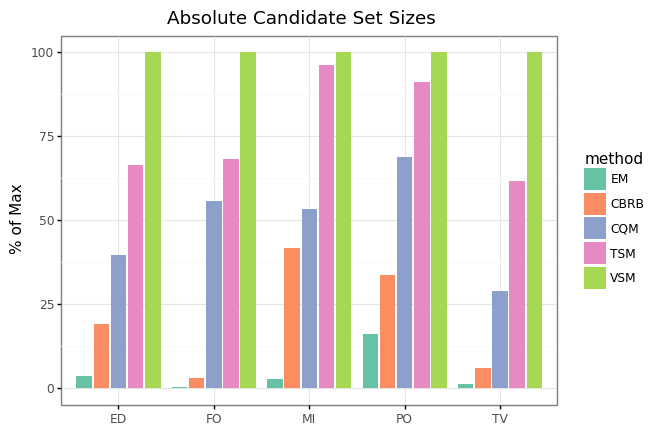

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/absoluteSetSizes.png


In [26]:
import role_matching.MetricHelperMethods as mhm
#Reduction rate computation for military:

#28.06.2022_17:19:23.480 [main] DEBUG d.h.r.e.s.SimpleAllPairSampler[75] - Finshed military with sample size:1000000 with misses: 88280922
#28.06.2022_19:24:35.140 [main] DEBUG d.h.r.e.s.SimpleAllPairSampler[75] - Finshed politics with sample size:1000000 with misses: 41041877
#28.06.2022_21:54:55.369 [main] DEBUG d.h.r.e.s.SimpleAllPairSampler[75] - Finshed football with sample size:1000000 with misses: 38466606
#29.06.2022_00:40:12.254 [main] DEBUG d.h.r.e.s.SimpleAllPairSampler[75] - Finshed tv_and_film with sample size:1000000 with misses: 50646743
#29.06.2022_03:16:43.917 [main] DEBUG d.h.r.e.s.SimpleAllPairSampler[75] - Finshed education with sample size:1000000 with misses: 28997770

dsToAllPairs = {
    "military": {"allPairs":4263199291,"nMissesSVA":88280922,"nHitsSVA":1000000},
    "tv_and_film": {"allPairs":23657801481,"nMissesSVA":50646743,"nHitsSVA":1000000},
    "politics": {"allPairs":2223411270,"nMissesSVA":41041877,"nHitsSVA":1000000},
    "education": {"allPairs":2737889001,"nMissesSVA":28997770,"nHitsSVA":1000000},
    "football": {"allPairs":53116323211,"nMissesSVA":38466606,"nHitsSVA":1000000},
}

#methodNames=["isInExactMatchBlocking","isInSequenceBlocking","isInValueSetBlocking","isInTSMBlockingNoWildcard","isInStrictBlockingNoDecay","isRMTargetRecall95","isIncbrbWithOutDecayTargetRecall95","isIncbrbWithDecayTargetRecall95"]
#methodNames = ['isInValueSetBlocking','isInValueSetBlockingWithFilter','isInStrictBlockingNoDecay','isInStrictBlockingNoDecayWithFilter',"isInTSMBlockingNoWildcard","isInTSMBlockingWithFilter"]#,"isInTSMBlockingWithFilter"]
methodNames = ['isInExactMatchBlockingWithFilter','isInStrictBlockingNoDecayWithFilter','isInSequenceBlockingWithFilter','isInTSMBlockingWithFilter','isInValueSetBlockingWithFilter']
#methodNames = ['isInExactMatchBlocking','isInStrictBlockingNoDecay','isInSequenceBlocking','isInTSMBlockingNoWildcard','isInValueSetBlocking']

methodNamesToShortMethodName = {
    'isInExactMatchBlockingWithFilter':"EM",
    'isInStrictBlockingNoDecayWithFilter':"CBRB",
    'isInSequenceBlockingWithFilter':"CQM",
    'isInTSMBlockingWithFilter':"TSM",
    'isInValueSetBlockingWithFilter':"VSM"
}
# methodNamesToShortMethodName = {
#     'isInExactMatchBlocking':"EM",
#     'isInStrictBlockingNoDecay':"CBRB",
#     'isInSequenceBlocking':"CQM",
#     'isInTSMBlockingNoWildcard':"TSM",
#     'isInValueSetBlocking':"VSM"
# }

#print("dataset","#TP","EM,,","CSM,,","VSM,,","RM,,","FCBRM (ND),,","FCBRM (D),,","CBRM (ND),,","CBRM (D),,",sep=",")
#print("dataset","#Total Pairs","#Total 1VA","EM,,","CSM,,","VSM,,","TSM (NWC),,","FCBRM (ND),,","RM ,,","CBRB (ND),,","CBRB (D),,",sep=",")
print("dataset","#Total Pairs","EM","CBRB","QSM","TSM","VSM",sep=",")
#print(",," + (",RRAP"* (len(methodNames))))
finalDSRows = []
for (ds,thisDsAllPairsSample) in groupedByDS:
    #print("--------------------------------------------------------------------")

    #print("--------------------------------------------------------------------")
    #thisDsAllPairsSample = dfAllPairsSample[dfAllPairsSample['dataset']==ds]
    nAllPairs = dsToAllPairs[ds]["allPairs"]
    nHitsSVA = dsToAllPairs[ds]["nHitsSVA"]
    nMissesSVA = dsToAllPairs[ds]["nMissesSVA"]
    estimatedCountSVAPairs = round((nHitsSVA / (nHitsSVA+nMissesSVA)) * nAllPairs)
    nHits90VA2DA = len(thisDsAllPairsSample[thisDsAllPairsSample['isInDVA2VA95Blocking']].index)
    nMisses90VA2DA = len(thisDsAllPairsSample[thisDsAllPairsSample['isInDVA2VA95Blocking']].index)
    #printReductionRate("AllPairs","SVA",nHitsSVA,nMissesSVA,nAllPairs)
    print(ds,nAllPairs,sep=",",end=",")
    for method in methodNames:
        thisDF = thisDsAllPairsSample[thisDsAllPairsSample[method]]
        nHitsThisMethod = len(thisDF.index)
        nMissesThisMethod = nMissesSVA + len(thisDsAllPairsSample.index) - nHitsThisMethod
        n,rrAll = mhm.getReductionRate(nHitsThisMethod,nMissesThisMethod,nAllPairs)
        finalDSRows.append({"dataset":ds,"method":methodNamesToShortMethodName[method],"n":n,"rr":rrAll})
        _,rr1VA = mhm.getReductionRate(nHitsThisMethod,len(thisDsAllPairsSample) - nHitsThisMethod,estimatedCountSVAPairs)
        rr95 = mhm.getReductionRateToOtherMethod(method,"isInDVA2VA95Blocking",thisDsAllPairsSample)
        #print(round(100*rrAll,6),sep=",",end=",")
        print(round(n),sep=",",end=",")
    print("")
        # printReductionRate("All Pairs",method,nHitsThisMethod,len(thisDsAllPairsSample) - nHitsThisMethod,nAllPairs)
        # printReductionRate("SVA",method,nHitsThisMethod,len(thisDsAllPairsSample) - nHitsThisMethod,estimatedCountSVAPairs)
        # printReductionRateToOtherMethod(method,"isInDVA2VA95Blocking",thisDsAllPairsSample)
finalDF = pd.DataFrame(finalDSRows)
#get maxima:
grouped = finalDF.groupby("dataset",).agg({'n':"max"}).to_dict("index")
finalDF["% of Max"] = finalDF.apply(lambda r: 100*(r["n"] / grouped[r["dataset"]]["n"]),axis=1)
for ds in finalDF["dataset"].unique():
    print(ds,grouped[ds]["n"])
print(finalDF)
finalDF['method'] = finalDF['method'].astype("category").cat.reorder_categories(['EM', 'CBRB', "CQM", "TSM", "VSM"])
rm.addShortDataset(finalDF)
plot = ggplot(finalDF,aes(x = 'datasetShort',fill="method",y="% of Max")) +xlab("") + geom_bar(position=position_dodge2(preserve = "single"),stat="identity") + ggtitle("Absolute Candidate Set Sizes") + theme(text=element_text(size=14)) + theme_bw() + scale_fill_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exportedPlots/absoluteSetSizes.png")
#
# print(dfTruePositivesOnly.columns)
# plot = ggplot(dfTruePositivesOnlyDF1,aes(x = 'datasetShort',fill="bucket")) +xlab("") + theme_bw() + geom_bar(position=position_dodge2(preserve = "single")) + ggtitle("True Positives - DGS") + ylim(0,60) + theme(text=element_text(size=14)) \
#        #+  geom_text(aes(label = "..count.."), stat = "count")
# print(plot)


# # Reduction Ratio parametrized:

In [7]:


import glob
import os
import pandas as pd
import role_matching.EvaluationHelperMethods as rm
import role_matching.MetricHelperMethods as mhm

dsToAllPairs = {
    "military": {"allPairs":4263199291,"nMissesSVA":88280922,"nHitsSVA":1000000},
    "tv_and_film": {"allPairs":23657801481,"nMissesSVA":50646743,"nHitsSVA":1000000},
    "politics": {"allPairs":2223411270,"nMissesSVA":41041877,"nHitsSVA":1000000},
    "education": {"allPairs":2737889001,"nMissesSVA":28997770,"nHitsSVA":1000000},
    "football": {"allPairs":53116323211,"nMissesSVA":38466606,"nHitsSVA":1000000},
}

dfAllPairsParametrized = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/home/leon/data/dataset_versioning/finalExperiments/allPairsSample/csvFilesNew/*.csv"))))
print(dfAllPairsParametrized.columns)
groupedByDsParametrized = dfAllPairsParametrized.groupby("dataset")

Index(['dataset', 'id1', 'id2', 'RM_Gamma', 'CBRB_Beta', 'Relaxed_CBRB_Gamma',
       'hasTransitionOverlap'],
      dtype='object')


In [8]:
oldGoldStandard = rm.readGoldStandardEvaluation(True)
newGoldStandard = rm.readGoldStandardEvaluation(False)
pd.options.mode.chained_assignment = None

thresholds = []
for i in range(101):
    thresholds.append(i/100)
finalDFRows = []
methods = ["RM_Gamma","CBRB_Beta"]

methodsToRecallScoreNames = {
    "RM_Gamma":"exactSequenceMatchPercentage",
    "CBRB_Beta":"decayScore",
    "Relaxed_CBRB_Gamma":"compatibilityPercentageNoDecay"
}

methodsToPlotNames = {
    "RM_Gamma":"RM",
    "CBRB_Beta":"CBRB"
}


bucketAndDatasetToWeight, _ = rm.getBucketAndDatasetToWeight()
# mhm.printRecallForNonparametrizedMethodsDF(shortName,df[df['dataset']==dsName],methodNames,weighted,bucketAndDatasetToWeight)
# mhm.printRecallForNonparametrizedMethodsDF("Micro-AVG",df,methodNames,weighted,bucketAndDatasetToWeight)
# mhm.printMacroAveragesRecall("Macro-AVG",df,methodNames,weighted,bucketAndDatasetToWeight)


def getRecall(oldGoldStandard, ds, scoreName, weighted):
    oldGoldStandardFiltered = oldGoldStandard[oldGoldStandard["dataset"]==ds]
    oldGoldStandardFiltered['currentScoreWithCutoff'] = ((oldGoldStandardFiltered[scoreName] !=-1) & (oldGoldStandardFiltered[scoreName]>=t))
    recallDGS = mhm.getRecall(oldGoldStandardFiltered,'currentScoreWithCutoff',weighted,bucketAndDatasetToWeight)
    return recallDGS

print(oldGoldStandard['decayScore'].describe())

for method in methods:
    print("processing",method)
    plotnameMethod = methodsToPlotNames[method]
    for t in thresholds:
    #print("Processing ",ds)
        print("processing",t)
        avgN = 0
        avgRR = 0
        avgRecallDGS = 0
        avgRecallRGS = 0
        for(ds,dfGrouped) in groupedByDsParametrized:
            scoreName = methodsToRecallScoreNames[method]
            #recall old gold standard:
            recallDGS = getRecall(oldGoldStandard,ds,scoreName,False)
            recallRGS = getRecall(newGoldStandard,ds,scoreName,True)
            #recall new gold standard:
            # newGoldStandardFiltered = newGoldStandard[newGoldStandard["dataset"]==ds]
            # newGoldStandardFiltered['currentScoreWithCutoff'] = ((newGoldStandardFiltered[scoreName] !=-1) & (newGoldStandardFiltered[scoreName]>=t))
            # recallRGS = mhm.getRecall(newGoldStandardFiltered,"'currentScoreWithCutoff'",True,bucketAndDatasetToWeight)
            #reduction ratio:
            nAllPairs = dsToAllPairs[ds]["allPairs"]
            nMissesSVA = dsToAllPairs[ds]["nMissesSVA"]
            thisDF = dfGrouped[((dfGrouped[method]>=t) & (dfGrouped["hasTransitionOverlap"]))]
            #thisDF = dfGrouped[dfGrouped[method]>=t]
            nHitsThisMethod = len(thisDF.index)
            nMissesThisMethod = nMissesSVA + len(dfGrouped.index) - nHitsThisMethod
            n,rrAll = mhm.getReductionRate(nHitsThisMethod,nMissesThisMethod,nAllPairs)
            if(rrAll>1):
                print(n,rrAll,nHitsThisMethod,nMissesThisMethod,nAllPairs)
            avgN +=n
            avgRR += rrAll
            avgRecallDGS += recallDGS
            avgRecallRGS += recallRGS
            finalDFRows.append({"n":n,"rr":100*rrAll,"method":plotnameMethod,"threshold":t,"dataset":ds,"recall":recallDGS,"GS":"DGS"})
            finalDFRows.append({"n":n,"rr":100*rrAll,"method":plotnameMethod,"threshold":t,"dataset":ds,"recall":recallRGS,"GS":"RGS"})
        avgN = avgN / len(groupedByDsParametrized)
        avgRR = avgRR / len(groupedByDsParametrized)
        avgRecallDGS = avgRecallDGS / len(groupedByDsParametrized)
        avgRecallRGS = avgRecallRGS / len(groupedByDsParametrized)
        finalDFRows.append({"n":avgN,"rr":100*avgRR,"method":plotnameMethod,"threshold":t,"dataset":"MAA","recall":avgRecallDGS,"GS":"DGS"})
        finalDFRows.append({"n":avgN,"rr":100*avgRR,"method":plotnameMethod,"threshold":t,"dataset":"MAA","recall":avgRecallRGS,"GS":"RGS"})
finalDF = pd.DataFrame(finalDFRows)
print(finalDF.describe())

/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/leon/PycharmProjects/RoleMatchingEvaluation/role_matching/EvaluationHelperMethods.

count    1500.000000
mean        0.352927
std         0.616159
min        -1.000000
25%         0.000000
50%         0.330000
75%         1.000000
max         1.000000
Name: decayScore, dtype: float64
processing RM_Gamma
processing 0.0
processing 0.01
processing 0.02
processing 0.03
processing 0.04
processing 0.05
processing 0.06
processing 0.07
processing 0.08
processing 0.09
processing 0.1
processing 0.11
processing 0.12
processing 0.13
processing 0.14
processing 0.15
processing 0.16
processing 0.17
processing 0.18
processing 0.19
processing 0.2
processing 0.21
processing 0.22
processing 0.23
processing 0.24
processing 0.25
processing 0.26
processing 0.27
processing 0.28
processing 0.29
processing 0.3
processing 0.31
processing 0.32
processing 0.33
processing 0.34
processing 0.35
processing 0.36
processing 0.37
processing 0.38
processing 0.39
processing 0.4
processing 0.41
processing 0.42
processing 0.43
processing 0.44
processing 0.45
processing 0.46
processing 0.47
processing 0.48


                 n         rr method  threshold      dataset    recall   GS
0     4.417456e+04  99.998387     RM        0.0    education  1.000000  DGS
1     4.417456e+04  99.998387     RM        0.0    education  1.000000  RGS
2     5.910456e+07  99.888726     RM        0.0     football  1.000000  DGS
3     5.910456e+07  99.888726     RM        0.0     football  1.000000  RGS
4     2.307299e+05  99.994588     RM        0.0     military  1.000000  DGS
...            ...        ...    ...        ...          ...       ...  ...
2419  3.860651e+03  99.999826   CBRB        1.0     politics  0.622542  RGS
2420  4.580696e+03  99.999981   CBRB        1.0  tv_and_film  0.777778  DGS
2421  4.580696e+03  99.999981   CBRB        1.0  tv_and_film  0.504398  RGS
2422  3.052687e+04  99.999746   CBRB        1.0          MAA  0.735312  DGS
2423  3.052687e+04  99.999746   CBRB        1.0          MAA  0.691186  RGS

[2424 rows x 7 columns]


/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


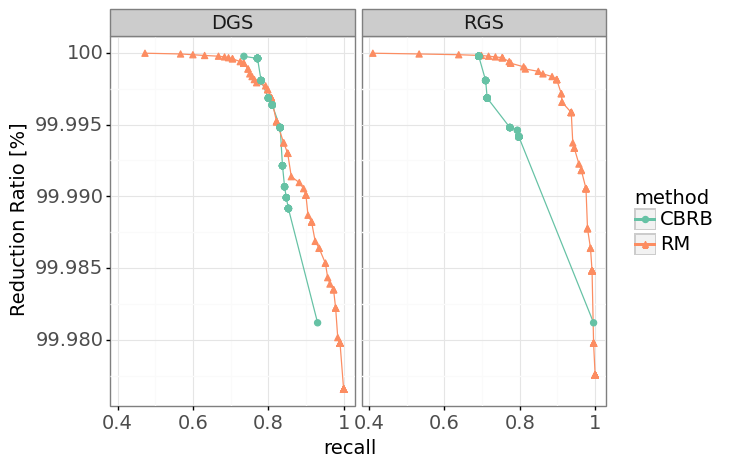

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/rrParametrized.png
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

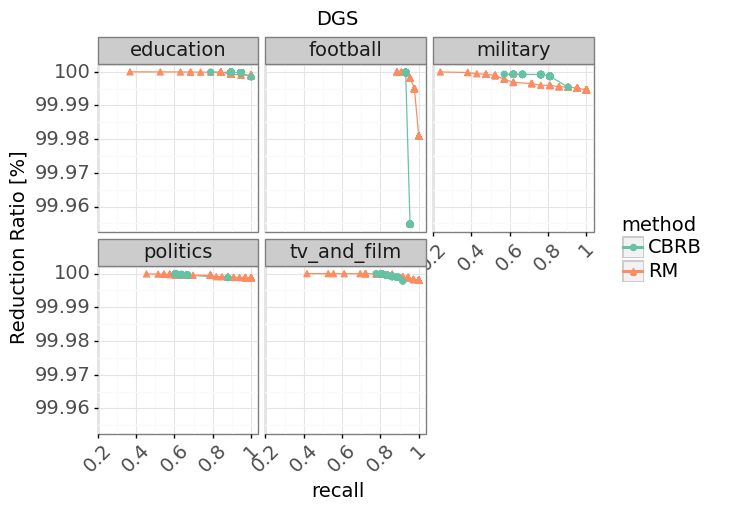

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/rrDGSAll.png
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

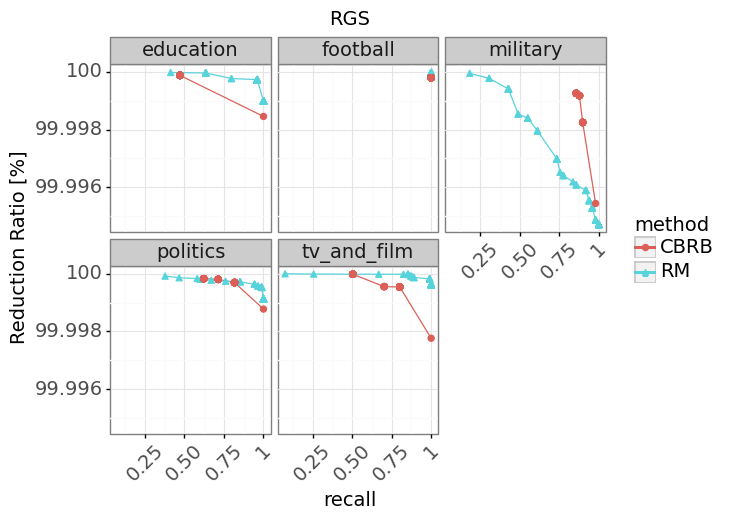

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/rrRGSAll.png
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

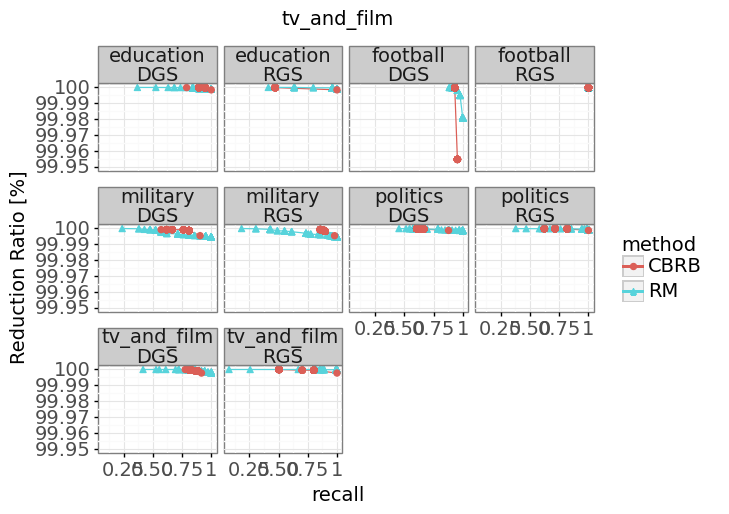

/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


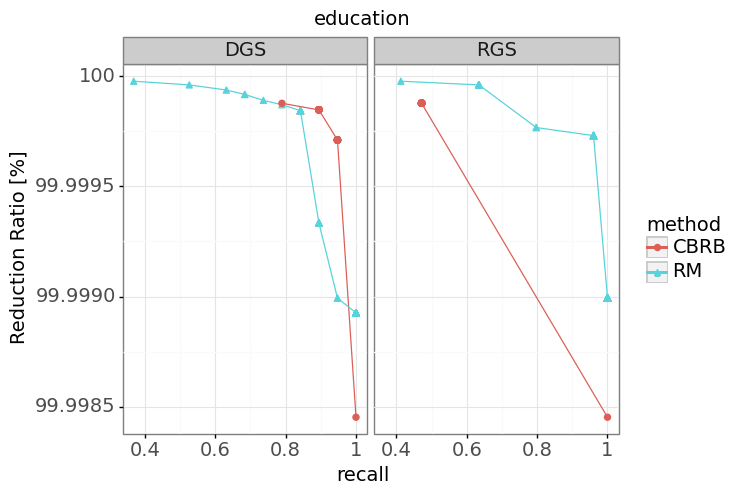

/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


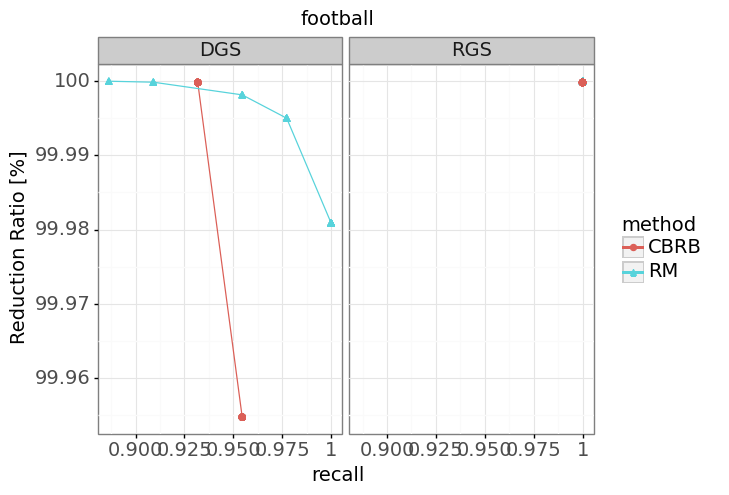

/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


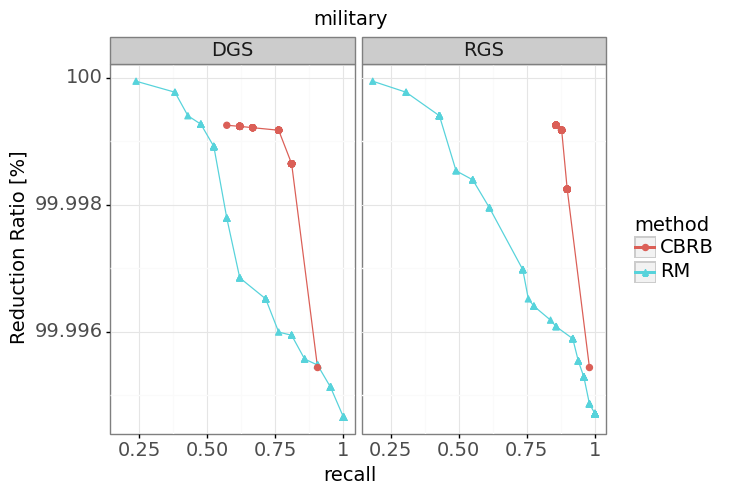

/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


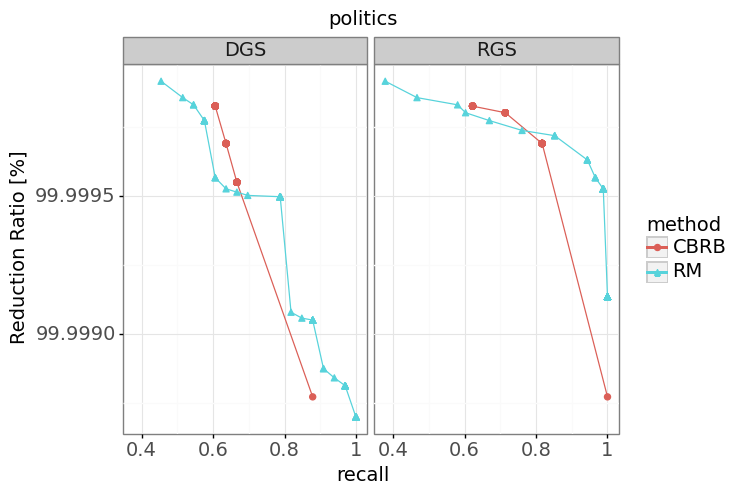

/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


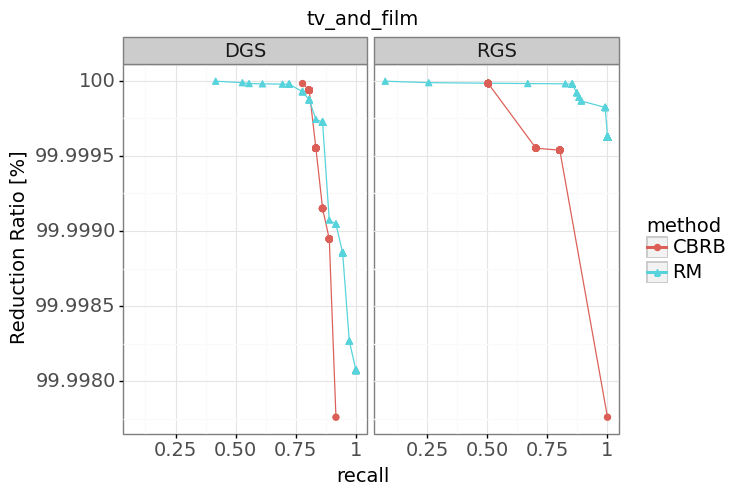

In [9]:
from plotnine import *
from plotnine.data import *
print(finalDF)


def createSmoothedRR(x, finalDF):
    gs = x["GS"]
    method = x["method"]
    dataset = x["dataset"]
    recall = x["recall"]
    sorted = finalDF[(finalDF["dataset"]==dataset) & (finalDF["method"]==method) & (finalDF["GS"]==gs) & (finalDF["recall"]>=recall)].sort_values('rr',ascending=False)
    bestRR = sorted.iloc[0]["rr"]
    return bestRR

reductionRatioSmoothed = finalDF.apply(lambda x: createSmoothedRR(x,finalDF),axis=1)
finalDF["rrSmooth"] = reductionRatioSmoothed
finalDFMAA = finalDF[finalDF['dataset']=="MAA"]
plot = ggplot(finalDFMAA, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap("GS") + theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + scale_color_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exportedPlots/rrParametrized.png")
finalDFNOMAA = finalDF[finalDF['dataset']!="MAA"]
finalDFNOMAADGS = finalDFNOMAA[finalDFNOMAA["GS"]=="DGS"]
finalDFNOMAARGS = finalDFNOMAA[finalDFNOMAA["GS"]=="RGS"]

plot = ggplot(finalDFNOMAADGS, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap(["dataset"]) +ggtitle("DGS")+ theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + theme(axis_text_x = element_text(angle=45)) + scale_color_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exportedPlots/rrDGSAll.png")

plot = ggplot(finalDFNOMAARGS, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap(["dataset"]) +ggtitle("RGS")+ theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + theme(axis_text_x = element_text(angle=45))
print(plot)
plot.save("exportedPlots/rrRGSAll.png")

plot = ggplot(finalDFNOMAA, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap(["dataset","GS"]) +ggtitle(ds)+ theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + ylim(99.95,100)
print(plot)
for ds in finalDFNOMAA["dataset"].unique():
    thisDF = finalDFNOMAA[finalDFNOMAA["dataset"]==ds]
    plot = ggplot(thisDF, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap("GS") +ggtitle(ds)+ theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]")
    print(plot)
# plot = ggplot(finalDFMAA, aes(x ='recall RGS', y='rr', color="method")) + geom_line() + geom_point() + theme_bw() + theme(text=element_text(size=14))
# print(plot)

In [10]:
print(finalDFMAA[(finalDFMAA['recall']>=0.95) & (finalDFMAA['GS']=="RGS")])

                 n         rr method  threshold dataset    recall   GS  \
11    1.200396e+07  99.975549     RM       0.00     MAA  1.000000  RGS   
23    1.200396e+07  99.975549     RM       0.01     MAA  1.000000  RGS   
35    1.200396e+07  99.975549     RM       0.02     MAA  1.000000  RGS   
47    1.200396e+07  99.975549     RM       0.03     MAA  1.000000  RGS   
59    1.200396e+07  99.975549     RM       0.04     MAA  1.000000  RGS   
...            ...        ...    ...        ...     ...       ...  ...   
755   4.179464e+06  99.990962     RM       0.62     MAA  0.963506  RGS   
767   3.977826e+06  99.991369     RM       0.63     MAA  0.963506  RGS   
779   3.762006e+06  99.991805     RM       0.64     MAA  0.963506  RGS   
791   3.541777e+06  99.992248     RM       0.65     MAA  0.957060  RGS   
1223  9.127796e+06  99.981199   CBRB       0.00     MAA  0.995920  RGS   

       rrSmooth  
11    99.977562  
23    99.977562  
35    99.977562  
47    99.977562  
59    99.977562  
...